<h1>Reddit project: Classifying r/conspiracy and r/news</h1>

The following project seeks to classify comments from the r/news and r/conspiracy subreddits. For more information, please see the project README in this notebook's parent directory.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import RegexpTokenizer
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy import sparse
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB, CategoricalNB
from sklearn.neighbors import KNeighborsClassifier

read in both of the reddit csv files, one for each subreddit

In [2]:
news = pd.read_csv('./news.csv')
consp = pd.read_csv('./conspiracy.csv')

In [3]:
news.shape

(20601, 4)

In [4]:
consp.shape

(22281, 4)

In [5]:
news.head()

,author,created_utc,post,subreddit
0,egalroc,1600303999,At this point all Trump supporters are Russian...,news
1,Crooked16th,1600303997,https://www.theguardian.com/world/2020/sep/15/...,news
2,Kinolee,1600303996,&gt; the people getting clean\n\nMost likely n...,news
3,cakevictim,1600303996,This is definitely not the time to have that t...,news
4,oooortclouuud,1600303991,"once in the title, once in the article. your s...",news


In [6]:
consp.head()

,author,created_utc,post,subreddit
0,Rusure111111,1600303937,thats what happens when you sell your soul,conspiracy
1,ZweiDunkleJungen,1600303934,Well they certainly aren't scared a green part...,conspiracy
2,brevz123,1600303934,https://youtu.be/DgsQelXM-go?t=388\n\nLOL i'm ...,conspiracy
3,e-Pat,1600303933,"Let me correct your title: \n""The people defen...",conspiracy
4,Foxopotamus,1600303923,"I watched a really good “documentary,” for lac...",conspiracy


In [7]:
df = pd.concat([news, consp], axis=0, ignore_index=True)

In [8]:
df.shape

(42882, 4)

Subreddit changed to binary 1:news 0:conspiracy

In [9]:
df.subreddit = df.subreddit.map({'conspiracy':0, 'news':1})

In [10]:
df.head()

,author,created_utc,post,subreddit
0,egalroc,1600303999,At this point all Trump supporters are Russian...,1
1,Crooked16th,1600303997,https://www.theguardian.com/world/2020/sep/15/...,1
2,Kinolee,1600303996,&gt; the people getting clean\n\nMost likely n...,1
3,cakevictim,1600303996,This is definitely not the time to have that t...,1
4,oooortclouuud,1600303991,"once in the title, once in the article. your s...",1


In [11]:
df.duplicated(subset=None, keep='first').value_counts()
#checking for duplicates

False    42881
True         1
dtype: int64

In [12]:
df.drop_duplicates(inplace=True)
#for some reason there is one duplicate item. We'll go ahead and drop it.

In [13]:
df.groupby('author')['author'].value_counts().sort_values(ascending=False)
#checking to see the distribution of authors

author                author              
FeniZio94             FeniZio94               162
MakeItRainSheckels    MakeItRainSheckels      139
ifhysm                ifhysm                  127
SchwarzerKaffee       SchwarzerKaffee         109
RussianBalconySafety  RussianBalconySafety    109
                                             ... 
Siretruck             Siretruck                 1
SireRequiem           SireRequiem               1
Sirbesto              Sirbesto                  1
Sir_Vexer             Sir_Vexer                 1
zzorga                zzorga                    1
Name: author, Length: 16464, dtype: int64

In [14]:
# Print English stopwords.
print(stopwords.words("english"))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [15]:
df.head()

,author,created_utc,post,subreddit
0,egalroc,1600303999,At this point all Trump supporters are Russian...,1
1,Crooked16th,1600303997,https://www.theguardian.com/world/2020/sep/15/...,1
2,Kinolee,1600303996,&gt; the people getting clean\n\nMost likely n...,1
3,cakevictim,1600303996,This is definitely not the time to have that t...,1
4,oooortclouuud,1600303991,"once in the title, once in the article. your s...",1


<h1>Filtering functions to prepare data for modeling</h1>

In [16]:
stop_words = stopwords.words("english")
new_words = ['youd', 'im', 'ive', 'weve', 'aint', 'ain\'t', "i'm", "i'll", "they've", "it'll", "can't", "we've",
             "that's", "there's", "don't", "might've", "they're", "i've", "he's", "she's", "i've", 'news', 'conspiracy']
for i in new_words:
    stop_words.append(i)

In [17]:
def prepare_posts(df):
    lemmatizer = WordNetLemmatizer()
    
    #capital letters tallied
    df["cl_count"]  = df.apply(lambda x: sum([1 for i in x.post if i.isupper()]), axis=1) 
    #all capital letters converted to lowercase
    df.post = df.post.str.lower() 
    #creation of new filtered column in dataframe to put clean text
    df['filtered'] = df['post']
    #exclamation point count
    df["exc_count"]  = df.apply(lambda x: sum([1 for i in x.post if i == "!"]), axis=1) 
    #question marks tallied
    df["qm_count"]  =  df.apply(lambda x: sum([1 for i in x.post if i == "?"]), axis=1)
    #character count of posts
    df["char_count"]  = df.apply(lambda x: len(x.post), axis=1)
    #word count of posts
    df["word_count"]  = df.apply(lambda x: len(x.post.split()), axis=1)
    #Url count within posts
    df["url_count"]  = df.apply(lambda x: len(re.findall(r'http\S+|www.\S+', x.post)), axis=1)
    #amount of numbers appearing in posts
    df["number_count"] = df.apply(lambda x: len(re.findall(r'\d*\.\d+|\d+', x.post)), axis=1)
    #apostrophe s count in posts
    df['apos_s_count'] = df.apply(lambda x: len(re.findall("'s", x.post)), axis=1)
    #count of elongated vowels like aaaaaaaaaaa eeeeeeeee etc
    df['elongated_vowels'] = df.apply(lambda x: len(re.findall("uuu+|aaa+|iii|eee+|ooo+", x.post)), axis=1)
    #tally of question words in post
    df["q_word_count"] = df.apply(lambda x: len(re.findall('who', x.post)) + len(re.findall('what', x.post)) + len(re.findall('when', x.post)) + len(re.findall('why', x.post)) + len(re.findall('where', x.post)) + len(re.findall('how', x.post)), axis=1)
    #removes non-english characters
    df['filtered'] = df.apply(lambda x: x.post.encode("ascii", "ignore").decode(), axis=1)
    #removes html
    df['filtered'] = df['filtered'].replace(to_replace=r'http\S+|www.\S+',value='',regex=True)
    #number of times the word percent occurs or the % symbol occurs 
    df["percent_count"] = df.apply(lambda x: len(re.findall('percent', x.post)) + len(re.findall('%', x.post)), axis=1)
    #replace elongated vowels with shorter version in hopes of getting more accurate word vowel counts
    alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
    for i in alphabet:
        df['filtered'] = df['filtered'].replace(f'{i}{i}{i}+', f'{i}', regex=True)
#     df['filtered'] = df['filtered'].replace("eee+", "e", regex=True)
#     df['filtered'] = df['filtered'].replace("iii+", "i", regex=True)
#     df['filtered'] = df['filtered'].replace("ooo+", "o", regex=True)
#     df['filtered'] = df['filtered'].replace("uuu+", "u", regex=True)
    df['filtered'] = df['filtered'].replace('&gt;', ' ', regex=True) #replaces greater than sign
    df['filtered'] = df['filtered'].replace('&lt;', ' ', regex=True) #replaces less than sign
    df['filtered'] = df['filtered'].replace('\n\n', ' ', regex=True) #replaces \n\n
    df['filtered'] = df['filtered'].replace('[.,?!$%*&_+^\|)(\[:\];]', ' ', regex=True) #replaces punctuation and random characters
    df['filtered'] = df['filtered'].replace('\d', ' ', regex=True) #removes numbers
    df['filtered'] = df['filtered'].replace('[’”“]', "'", regex=True) #removes curly 's
    df['filtered'] = df['filtered'].replace("'s", "", regex=True) #removes apostrophe + s
    df['filtered'] = df['filtered'].replace("'", "", regex=True) #removes apostrophe
    df['filtered'] = df['filtered'].replace('\s-+', ' ', regex=True) #removes - but not from compound-words
    df['filtered'] = df['filtered'].replace('~+', ' ', regex=True) #replaces ~
    df['filtered'] = df['filtered'].replace('"', ' ', regex=True) #replaces "s
    df['filtered'] = df['filtered'].replace('\\+|/+', ' ', regex=True) #replaces /s and \s with space to separate a/b/c into a b c 
    for i in range(0,df.shape[0]):
        post = df['filtered'].iloc[i].split()
        meaningful_words = [i for i in post if not i in stop_words] #remove stop words
        lemma = [lemmatizer.lemmatize(i) for i in meaningful_words] #lemmatize words
        df['filtered'].iloc[i] = (" ".join(lemma))

prepare_posts(df)
prepare_posts(news)
prepare_posts(consp)

C:\Users\Athos\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [18]:
for i in df.iloc[0:20]['filtered']:
    print(i)

point trump supporter russian asset also youre cop still support donald bad apple
go dip shit
people getting clean likely kind rehab considering number death sure general health rehab drug rehab old sick patient
definitely time traditional wedding
title article statement wildly exaggerated
would need go hassle make second rubber stamp judge name print go along signature stamp
hope one closure yelp
call two mile bridge
thing-which-must-not-be-named
dont think thought fine think gamble like live die evacuate percent lose stuff think knew high risk probably couldnt bear leave end despite evacuation prep stayed took odds people possible recover losing everything fire would rather die gonna guess couple one couldnt leave everything behind one could hence prep change heart stay take chance
way definitively link wedding sorry
post credible link
need start publicly shaming people shit honestly wedding reception mr mr name directly linked death people didnt attend let see bastard still disregar

In [19]:
X = df.filtered
y = df.subreddit

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [21]:
vectorizer = CountVectorizer(analyzer = "word",
                            ngram_range=(1,1),
                            stop_words='english')

ngram_range of 1,4 was too much...no improvement seen and almost 1,000,000 columns

In [22]:
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [23]:
X_train.shape

(32160, 28441)

In [24]:
X_test.shape

(10721, 28441)

<h1>Baseline model</h1>

In [25]:
y_test.value_counts(normalize=True).mul(100).round(2)
#Baseline accuracy

0    51.96
1    48.04
Name: subreddit, dtype: float64

In [26]:
# Instantiate logistic regression model.
lr = LogisticRegression(max_iter=10000, random_state=42)

# Fit model to training data.
lr.fit(X_train, y_train)

# Evaluate model on training data.
lr.score(X_train, y_train)

0.8754975124378109

In [27]:
lr.score(X_test, y_test)

0.7274507975002332

baseline with tfidf vectorizer instead of count vectorizer

In [28]:
X = df['filtered']
y = df['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
vectorizer = TfidfVectorizer(analyzer = "word", ngram_range=(1,3), stop_words='english')
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)


lr1 = LogisticRegression(max_iter=10000, random_state=42, n_jobs=-1)
lr1.fit(X_train, y_train)
print(f'Training score: {lr1.score(X_train, y_train)}')
print(f'Testing score: {lr1.score(X_test, y_test)}')


Training score: 0.9343594527363184
Testing score: 0.7308086932189162


In [29]:
mnb = MultinomialNB(alpha=.4, fit_prior=False)
mnb.fit(X_train, y_train)
print(f'Training score: {mnb.score(X_train, y_train)}')
print(f'Testing score: {mnb.score(X_test, y_test)}')

Training score: 0.9859141791044777
Testing score: 0.7561794608711874


<h1>With feature engineered columns</h1>

In [25]:
features = ['filtered', 'cl_count', 'exc_count', 'qm_count', 'char_count', 'word_count', 'url_count', 'apos_s_count', 
'elongated_vowels', 'percent_count', 'q_word_count', 'number_count']
#All features

num_features = ['cl_count', 'exc_count', 'qm_count', 'char_count', 'word_count', 'url_count', 'apos_s_count', 
'elongated_vowels', 'percent_count', 'q_word_count', 'number_count']
#Just those I engineered

In [31]:
X = df[features]
y = df['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
vectorizer = TfidfVectorizer(analyzer = "word", ngram_range=(1,3), stop_words='english')
X_train_words = vectorizer.fit_transform(X_train['filtered'])
X_test_words = vectorizer.transform(X_test['filtered'])

# ss = StandardScaler()
# train_num_feats = ss.fit_transform(X_train[num_features].values)
# test_num_feats = ss.transform(X_test[num_features].values)

# train_num_feats = np.log1p(X_train[num_features].values)
# test_num_feats = np.log1p(X_test[num_features].values)

train_num_feats = X_train[num_features].values
test_num_feats = X_test[num_features].values

X_train = sparse.hstack((X_train_words, train_num_feats))
X_test = sparse.hstack((X_test_words, test_num_feats))

lr1 = LogisticRegression(max_iter=10000, random_state=42, n_jobs=-1)
lr1.fit(X_train, y_train)
print(f'Training score: {lr1.score(X_train, y_train)}')
print(f'Testing score: {lr1.score(X_test, y_test)}')


Training score: 0.9163246268656716
Testing score: 0.7339800391754501


Taking the log of features (which as seen in EDA below have a lot of right skew) did not seem to improve the predictive power of these features.

In [32]:
X = df[features]
y = df['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
vectorizer = TfidfVectorizer(analyzer = "word", ngram_range=(1,3), stop_words='english', max_df=0.4)
X_train_words = vectorizer.fit_transform(X_train['filtered'])
X_test_words = vectorizer.transform(X_test['filtered'])

# ss = StandardScaler()
# train_num_feats = ss.fit_transform(X_train[num_features].values)
# test_num_feats = ss.transform(X_test[num_features].values)

train_num_feats = np.log1p(X_train[num_features].values)
test_num_feats = np.log1p(X_test[num_features].values)

# train_num_feats = X_train[num_features].values
# test_num_feats = X_test[num_features].values

X_train = sparse.hstack((X_train_words, train_num_feats))
X_test = sparse.hstack((X_test_words, test_num_feats))

lr = LogisticRegression(max_iter=10000, random_state=42, n_jobs=-1)
lr.fit(X_train, y_train)
print(f'Training score: {lr.score(X_train, y_train)}')
print(f'Testing score: {lr.score(X_test, y_test)}')

Training score: 0.921455223880597
Testing score: 0.7309952429810652


Multinomial Naive Bayes with feature engineered columns

In [33]:
mnb = MultinomialNB(alpha=.4, fit_prior=False)
mnb.fit(X_train, y_train)
print(f'Training score: {mnb.score(X_train, y_train)}')
print(f'Testing score: {mnb.score(X_test, y_test)}')

Training score: 0.9843283582089553
Testing score: 0.7522619158660573


<h2>Best Model</h2>

Multinomial Naive Bayes without feature columns

In [34]:
X = df['filtered']
y = df['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
index = [i for i in X_test.index]
vectorizer = TfidfVectorizer(analyzer = "word", ngram_range=(1,3), stop_words=None, max_df=0.15, norm='l2')
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# ss = StandardScaler()
# train_num_feats = ss.fit_transform(X_train[num_features].values)
# test_num_feats = ss.transform(X_test[num_features].values)

mnb = MultinomialNB(alpha=.36, fit_prior=False)
mnb.fit(X_train, y_train)
print(f'Training score: {mnb.score(X_train, y_train)}')
print(f'Testing score: {mnb.score(X_test, y_test)}')

Training score: 0.9899564676616915
Testing score: 0.7594440817087958


In [35]:
cross_val_score(mnb, X_train, y_train, cv=5,  n_jobs=-1).mean()

0.7512437810945274

In [36]:
len(vectorizer.get_feature_names())

950100

In [37]:
pred_proba = mnb.predict_proba(X_test)

In [38]:
pred_proba

array([[0.56835935, 0.43164065],
       [0.67984801, 0.32015199],
       [0.32166876, 0.67833124],
       ...,
       [0.39955912, 0.60044088],
       [0.38435071, 0.61564929],
       [0.687601  , 0.312399  ]])

In [39]:
y_preds = mnb.predict(X_test)

In [40]:
test_df = df[df.index.isin(index)]

Exploration of decisions made by model

In [41]:
test_df['y_preds'] = y_preds
test_df['pred_proba'] = [i[0] for i in pred_proba]
# test_df[['post', 'subreddit', 'y_preds']].head(30)
test_df[test_df['y_preds'] > test_df['subreddit']][['post', 'subreddit', 'y_preds', 'pred_proba']].head()

<ipython-input-41-4ddcd8e4e459>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['y_preds'] = y_preds
<ipython-input-41-4ddcd8e4e459>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['pred_proba'] = [i[0] for i in pred_proba]


,post,subreddit,y_preds,pred_proba
20610,full quote from article\n&gt;we have clear sci...,0,1,0.315254
20625,iran and turkey have had dews for some time. i...,0,1,0.470881
20626,there’s a difference between having a policy a...,0,1,0.259081
20641,"huh, i thought libertarians spent most of thei...",0,1,0.398217
20654,thank you for this very informative historical...,0,1,0.050312


In [42]:
test_df[test_df['y_preds'] > test_df['subreddit']]['word_count'].describe()

count    2630.000000
mean       36.382129
std        61.085667
min         1.000000
25%         9.000000
50%        20.000000
75%        41.000000
max      1198.000000
Name: word_count, dtype: float64

In [43]:
test_df[test_df['y_preds'] < test_df['subreddit']]['word_count'].describe()

count    2741.00000
mean       41.15031
std        73.18203
min         1.00000
25%        11.00000
50%        23.00000
75%        48.00000
max      1589.00000
Name: word_count, dtype: float64

In [44]:
df.word_count.describe()

count    42881.000000
mean        37.145146
std         55.983657
min          1.000000
25%         10.000000
50%         21.000000
75%         43.000000
max       1614.000000
Name: word_count, dtype: float64

In [45]:
mnb.feature_log_prob_

array([[-13.85514262, -13.84538637, -13.84538637, ..., -14.0075152 ,
        -14.0075152 , -14.0075152 ],
       [-13.41605454, -14.00771952, -14.00771952, ..., -13.34588946,
        -13.56474908, -13.65845769]])

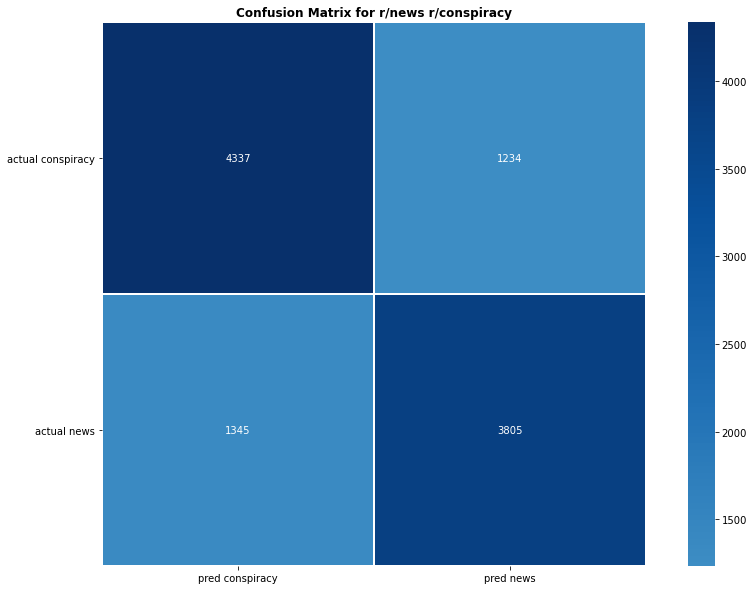

In [46]:
cm = confusion_matrix(y_test, y_preds)

cm_df = pd.DataFrame(cm, columns=['pred conspiracy', 'pred news'], 
                     index=['actual conspiracy', 'actual news'])

plt.figure(figsize=(15,10))
plt.title('Confusion Matrix for r/news r/conspiracy', fontweight='bold')
sns.heatmap(pd.DataFrame(cm_df), annot=True, square=True, linewidth=0.5, 
            fmt='', center=0, cmap="Blues",)
plt.yticks(rotation=0);

<h2>Gridsearching and pipelining to perfect best model</h2>

In [47]:
params = {
    'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
    'fit_prior': [True, False],
    }

grid = GridSearchCV(MultinomialNB(), 
                              params, #hyperparameters
                              cv=5, #number of cross validation folds
                              verbose=1) 

grid.fit(X_train, y_train)
grid.best_score_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    5.7s finished


0.7514925373134329

Gridsearch and pipelining best params used above in final model

In [48]:
X = df['filtered']
y = df['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

pipe = Pipeline([
    ('TfidfVectorizer', TfidfVectorizer()),
    ('MultinomialNB', MultinomialNB())
])

pipe_params = {'TfidfVectorizer__analyzer': ['word'], 
                 'TfidfVectorizer__stop_words': [None],
                 'TfidfVectorizer__ngram_range': [(1,3)], 
                 'TfidfVectorizer__max_df': [0.145, 0.147, 0.149, 0.15, 0.151],
                'TfidfVectorizer__binary': [False],
                  'TfidfVectorizer__norm': ['l2'],
                'MultinomialNB__alpha': [0.33, 0.34, 0.345, 0.35, 0.355, 0.36],
               'MultinomialNB__fit_prior': [False]
#                   'TfidfVectorizer__use_idf': [True],
#                   'TfidfVectorizer__smooth_idf': [True],
#                   'TfidfVectorizer__sublinear_tf': [False]
              }

pipe_grid = GridSearchCV(pipe, pipe_params, cv=5, verbose=1, n_jobs=-1)
pipe_grid.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.7min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('TfidfVectorizer', TfidfVectorizer()),
                                       ('MultinomialNB', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'MultinomialNB__alpha': [0.33, 0.34, 0.345, 0.35,
                                                  0.355, 0.36],
                         'MultinomialNB__fit_prior': [False],
                         'TfidfVectorizer__analyzer': ['word'],
                         'TfidfVectorizer__binary': [False],
                         'TfidfVectorizer__max_df': [0.145, 0.147, 0.149, 0.15,
                                                     0.151],
                         'TfidfVectorizer__ngram_range': [(1, 3)],
                         'TfidfVectorizer__norm': ['l2'],
                         'TfidfVectorizer__stop_words': [None]},
             verbose=1)

In [49]:
pipe_grid.best_params_

{'MultinomialNB__alpha': 0.36,
 'MultinomialNB__fit_prior': False,
 'TfidfVectorizer__analyzer': 'word',
 'TfidfVectorizer__binary': False,
 'TfidfVectorizer__max_df': 0.15,
 'TfidfVectorizer__ngram_range': (1, 3),
 'TfidfVectorizer__norm': 'l2',
 'TfidfVectorizer__stop_words': None}

In [50]:
pipe_grid.best_score_

0.7527985074626865

In [51]:
neg_class_prob_sorted = mnb.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted = mnb.feature_log_prob_[1, :].argsort()

print(np.take(vectorizer.get_feature_names(), neg_class_prob_sorted[:10]))
print(np.take(vectorizer.get_feature_names(), pos_class_prob_sorted[:10]))

['zyklon gas fuck' 'go every field' 'really politics real' 'go event died'
 'go event' 'really poor decision' 'go even obama' 'really prefer'
 'really prefer cover' 'go etc saying']
['logic also initial' 'left small crime' 'left slowly surely'
 'left slowly' 'left slap wrist' 'left slap' 'left situation everything'
 'left situation' 'left side arena' 'left shoulder']


<h1>EDA</h1>

In [52]:
cv_news = CountVectorizer(analyzer = "word")
news_words = cv_news.fit_transform(news.filtered)
news = pd.DataFrame(news_words.todense(), columns=cv_news.get_feature_names())

cv_consp = CountVectorizer(analyzer = "word")
consp_words = cv_consp.fit_transform(consp.filtered)
consp = pd.DataFrame(consp_words.todense(), columns=cv_consp.get_feature_names())

In [35]:
df.groupby('subreddit')['author'].nunique()

subreddit
0     6208
1    10385
Name: author, dtype: int64

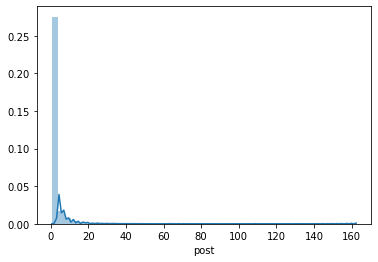

In [43]:
sns.distplot(df.groupby('author')['post'].count())

In [54]:
news_authors = []
consp_authors = []


for i in range(0, df.shape[0]):
    if df.iloc[i]['subreddit'] == 1:
        if df.iloc[i]['author'] in news_authors:
            pass
        else:
            news_authors.append(df.iloc[i]['author'])
    else:
        if df.iloc[i]['author'] in consp_authors:
            pass
        else:
            consp_authors.append(df.iloc[i]['author'])

In [55]:
len(news_authors)

10385

In [56]:
len(consp_authors)

6208

In [63]:
for i in news_authors:
    if i in consp_authors:
        both.append(i)
        
len(both)

258

In [65]:
len(consp_authors)+len(news_authors)-len(both)

16335

In [53]:
features

['filtered',
 'cl_count',
 'exc_count',
 'qm_count',
 'char_count',
 'word_count',
 'url_count',
 'apos_s_count',
 'elongated_vowels',
 'percent_count',
 'q_word_count',
 'number_count']

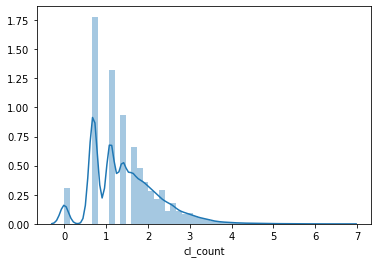

In [54]:
sns.distplot(np.log1p(df.cl_count))

In [55]:
df.cl_count.max()

792

C:\Users\Athos\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


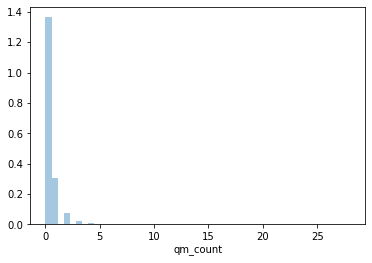

In [56]:
sns.distplot(df.qm_count)

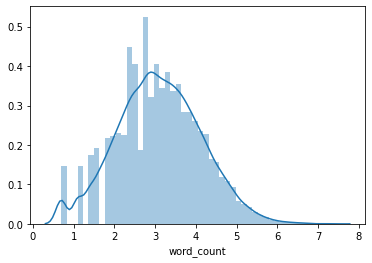

In [57]:
sns.distplot(np.log1p(df.word_count))

C:\Users\Athos\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


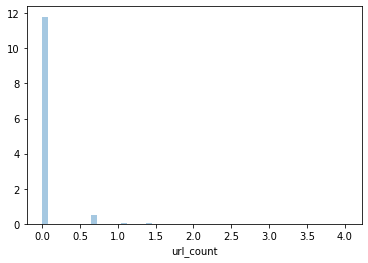

In [58]:
sns.distplot(np.log1p(df.url_count))

In [59]:
df.url_count.describe()

count    42881.000000
mean         0.085959
std          0.775396
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         55.000000
Name: url_count, dtype: float64

In [60]:
[i for i in df[df['url_count'] > 54]['post']]
# looking to see what post could possibly have 55 urls in it

['we all have eyes to see\n\nransacked target minneapolis\n\nhttps://streamable.com/b3u92p\n\n\n\nbuilding burning in minneapolis \n\nhttps://streamable.com/vh5nyu\n\n\n\nboy drove car into a store\n\nhttps://streamable.com/nrm2pn\n\n\n\npost office looted/destroyed https://streamable.com/v4vflf\n\n\n\nminneapolis third police precinct set on fire\n\nhttps://streamable.com/o27w75\n\n\n\nmore buildings on fire minneapolis\n\nhttps://streamable.com/8au2lf\n\n\n\nautoparts store getting destroyed/looted\n\nhttps://streamable.com/dum1r8\n\n\n\nautozone on fire\n\nhttps://streamable.com/vq9hrp\n\n\n\nlooting in minneapolis\n\nhttps://streamable.com/jfor5g\n\n\n\nadults loot with their children\n\nhttps://streamable.com/m4cr5j\n\n\n\ncars torched – minneapolis\n\nhttps://streamable.com/mmk9gr\n\n\n\nlooting an atm in minneapolis\n\nhttps://streamable.com/ht2oxv\n\n\n\nremains of destroyed/looted cub foods\n\nhttps://streamable.com/qhzlm7\n\n\n\nbusiness and stores on fire in minneapolis\n\nh

In [61]:
df[df['url_count'] > 10]
# looking to see what posts with over 10 urls look like: mostly from conspiracy subreddit

,author,created_utc,post,subreddit,cl_count,filtered,exc_count,qm_count,char_count,word_count,url_count,number_count,apos_s_count,elongated_vowels,q_word_count,percent_count
2474,RedeemedVulture,1600297021,i posted this reply for the other guy. it fits...,1,196,posted reply guy fit question everyone faith b...,0,3,4481,516,20,33,3,0,9,1
2679,RedeemedVulture,1600296405,"are you are defining ""rational"" as agreeing wi...",1,199,defining rational agreeing course bible writte...,0,4,4639,548,20,33,3,0,9,1
12077,ro_goose,1600270780,wait a minute... you think the defense product...,1,258,wait minute think defense production act invok...,0,6,5792,558,25,81,6,0,6,0
21542,DeadEndFred,1600299022,exactly. the rockefeller syndicate and their c...,0,85,exactly rockefeller syndicate cohort place cia...,0,2,2331,89,22,43,0,0,8,0
23250,Asshole411,1600291867,we all have eyes to see\n\nransacked target mi...,0,178,eye see ransacked target minneapolis building ...,0,10,3596,281,55,83,0,0,1,0
23906,Everythings,1600288866,\n\na doctor got a shock when in med school h...,0,792,doctor got shock med school read study mask we...,0,17,7003,681,17,255,0,0,3,4
24423,Everythings,1600286419,[https://www.reddit.com/r/conspiracy/comments/...,0,194,amp #x b amp #x b norwegian institute public h...,0,26,8261,716,15,94,1,0,6,0
24862,Bobby-Vinson,1600284660,&gt;“here is wisdom. let him that bath underst...,0,143,wisdom let bath understanding count number bea...,0,1,2906,283,13,23,0,7,3,0
25249,Asshole411,1600282952,&gt;fearing antifa earns you a membership\nto ...,0,116,fearing antifa earns membership short bus seat...,0,16,5313,514,18,47,1,0,3,1
26147,Asshole411,1600279066,"blame antifa for other stuff, like violence\n\...",0,104,blame antifa stuff like violence msnbc reporte...,1,28,4831,349,27,58,4,0,2,0


In [62]:
df.groupby('subreddit')['url_count'].mean()

subreddit
0    0.119698
1    0.049466
Name: url_count, dtype: float64

C:\Users\Athos\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


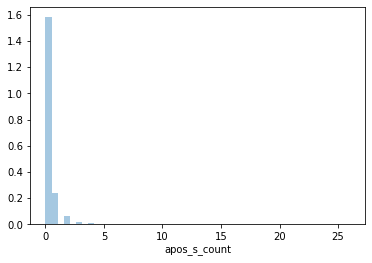

In [63]:
sns.distplot(df.apos_s_count)

In [64]:
df.apos_s_count.describe()

count    42881.000000
mean         0.268254
std          0.732910
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         26.000000
Name: apos_s_count, dtype: float64

In [65]:
df.elongated_vowels.describe()

count    42881.000000
mean         0.007346
std          0.106755
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          7.000000
Name: elongated_vowels, dtype: float64

C:\Users\Athos\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


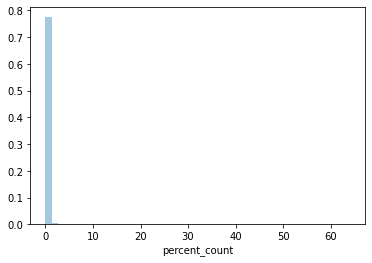

In [66]:
sns.distplot(df.percent_count)

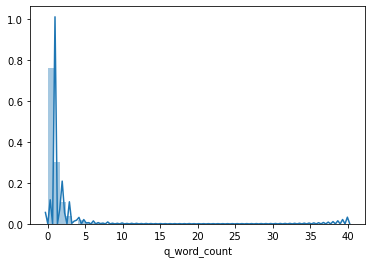

In [67]:
sns.distplot(df.q_word_count)

C:\Users\Athos\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


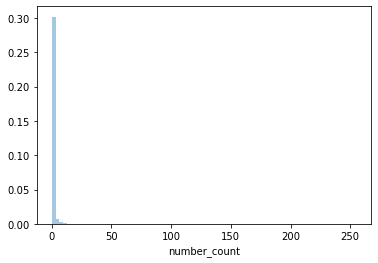

In [68]:
sns.distplot(df.number_count, bins=80);

Below I want to check if double letters are more frequently words with meaning or exageratively elongated vowels. These were eventually removed in the data processing function towards the top of this notebook.

In [69]:
[i for i in df[df.filtered.str.contains("aa+|ii+") == True]['post']][3:6]

['was he named joseph mengele ii ?',
 "dude i'm not even american, and america has been going down hill way before the 80's more like 60's/70's there post wwii socioeconomic models fail to bring them up to date with the late 20th century globalization.",
 'what you say is true, but maybe the "myth" of a "clean germany" is mostly about recognizing the effort and success germany has made in de-natification, especially given how recent wwii relatively is. it also draws a comparison to the begrudging and slow pace at which the u.s has dealt with its social problems.']

In [70]:
df.head()

,author,created_utc,post,subreddit,cl_count,filtered,exc_count,qm_count,char_count,word_count,url_count,number_count,apos_s_count,elongated_vowels,q_word_count,percent_count
0,egalroc,1600303999,at this point all trump supporters are russian...,1,5,point trump supporter russian asset also youre...,0,0,131,23,0,0,0,0,0,0
1,Crooked16th,1600303997,https://www.theguardian.com/world/2020/sep/15/...,1,0,go dip shit,0,0,126,6,1,3,0,0,0,0
2,Kinolee,1600303996,&gt; the people getting clean\n\nmost likely n...,1,4,people getting clean likely kind rehab conside...,0,0,178,31,0,0,0,0,0,0
3,cakevictim,1600303996,this is definitely not the time to have that t...,1,1,definitely time traditional wedding,0,0,65,11,0,0,0,0,0,0
4,oooortclouuud,1600303991,"once in the title, once in the article. your s...",1,0,title article statement wildly exaggerated,0,0,77,13,0,0,0,0,0,0


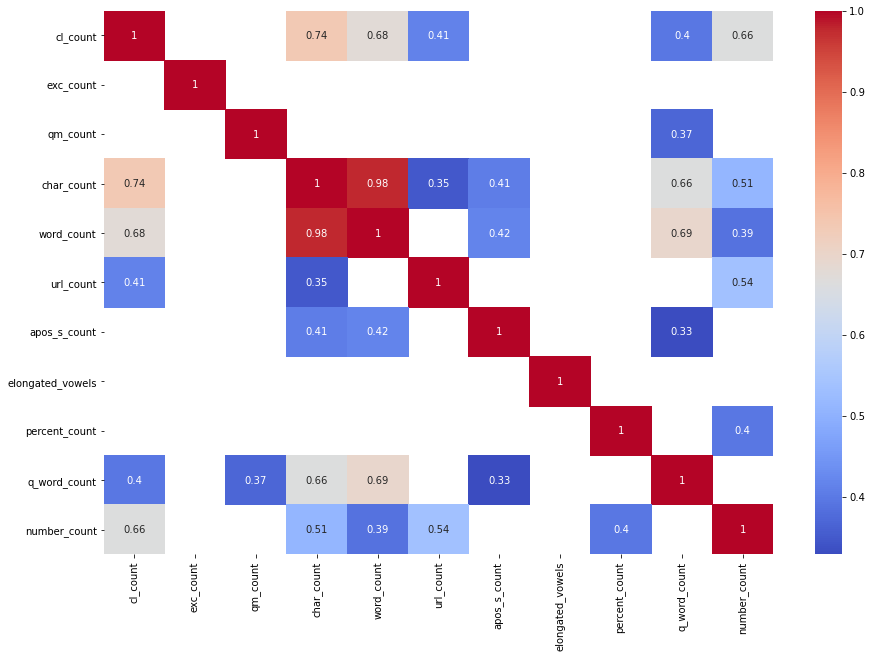

In [71]:
df_corr = df[features].corr()
plt.figure(figsize=(15,10))
sns.heatmap(df_corr[np.abs(df_corr)>.3], annot=True, cmap='coolwarm');

In [72]:
news.sum(axis=0).sort_values(ascending=True)[0:10]

diazepam             1
pheonix              1
phenotype            1
evenin               1
phenomenally         1
phasing              1
eventhoughtheyget    1
evasive              1
eventual             1
pharmaseuticals      1
dtype: int64

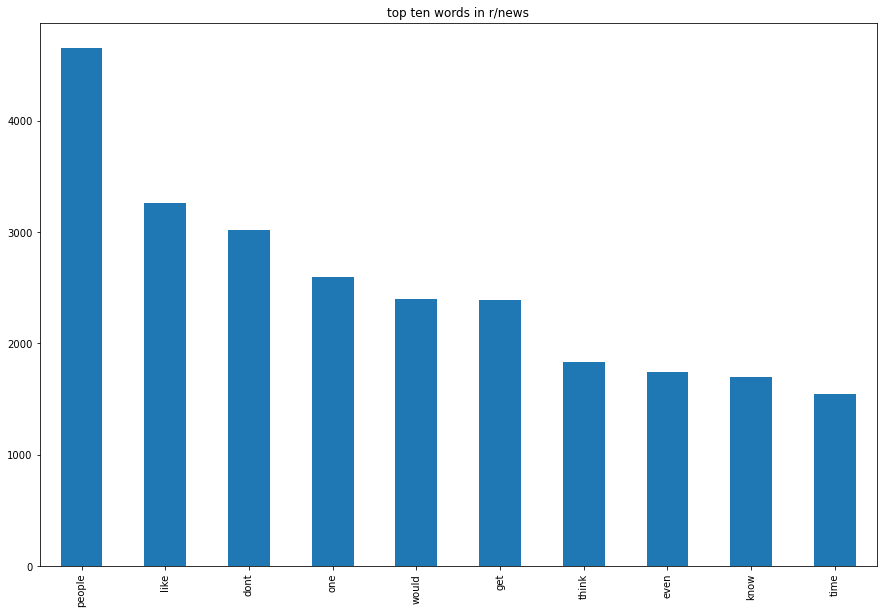

In [73]:
plt.figure(figsize=(15,10))
(news.sum(axis=0).sort_values(ascending=False)[0:10]).plot(kind='bar').set_title('top ten words in r/news');

In [74]:
consp.sum(axis=0).sort_values(ascending=True)[0:10]

zygeist      1
gooding      1
seeked       1
goodnight    1
goodwill     1
goody        1
seedy        1
goofball     1
seeded       1
googleing    1
dtype: int64

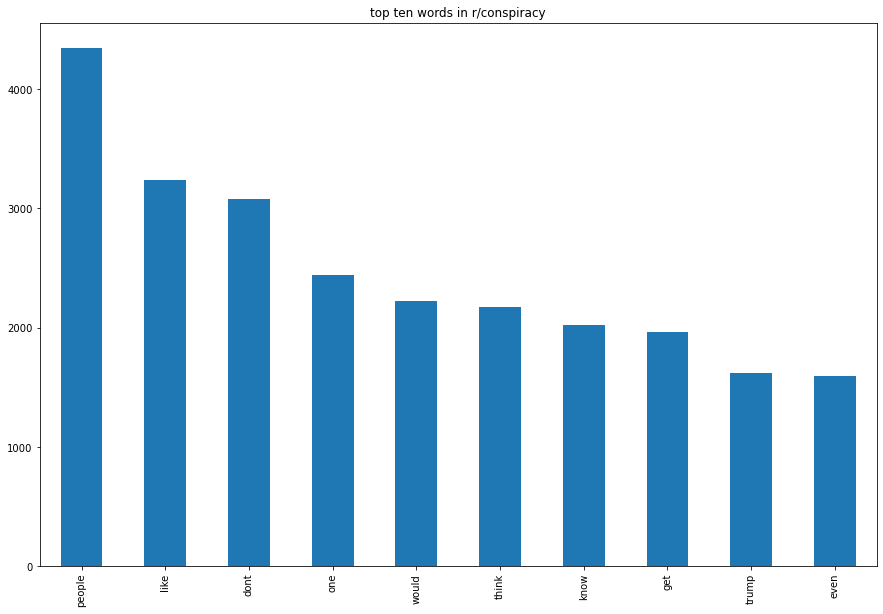

In [75]:
plt.figure(figsize=(15,10))
(consp.sum(axis=0).sort_values(ascending=False)[0:10]).plot(kind='bar').set_title('top ten words in r/conspiracy');

<h1>Decision Tree Models</h1>

I will attempt some different models to see if I achieve better results and can fight overfitting

In [76]:
X = df['filtered']
y = df['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
vectorizer = TfidfVectorizer(analyzer = "word", ngram_range=(1,3), stop_words=None, max_df=0.15)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

grid = GridSearchCV(estimator = DecisionTreeClassifier(),
                    param_grid = {'max_depth': [None],
                                  'ccp_alpha': [0, 0.001, 0.01, 0.1, 1, 10]},
                    cv = 5,
                    n_jobs=-1,
                    verbose = 1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 41.9min finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'ccp_alpha': [0, 0.001, 0.01, 0.1, 1, 10],
                         'max_depth': [None]},
             verbose=1)

In [77]:
grid.score(X_train, y_train)

0.9946517412935323

In [78]:
grid.score(X_test, y_test)

0.6226098311724653

In [79]:
grid.best_score_

0.6393034825870647

In [80]:
grid.best_params_

{'ccp_alpha': 0, 'max_depth': None}

<h3>Decision Tree</h3>

In [81]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
tree.score(X_train, y_train)

0.9946517412935323

In [82]:
tree.score(X_test, y_test)

0.6202779591456021

<h3>Random Forest</h3>

In [83]:
X = df['filtered']
y = df['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
vectorizer = TfidfVectorizer(analyzer = "word", ngram_range=(1,3), stop_words=None, max_df=0.15)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

forest = RandomForestClassifier(n_jobs=-1)
forest.fit(X_train, y_train)
forest.score(X_train, y_train)

0.9946517412935323

In [84]:
forest.score(X_test, y_test)

0.6998414327021732

<h2>SVM Model</h2>

without engineered features

In [85]:
X = df['filtered']
y = df['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, stratify=y, random_state=42)
vectorizer = TfidfVectorizer(analyzer = "word", ngram_range=(1,3), stop_words=None, max_df=0.15)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

lsvc = LinearSVC(max_iter=5000)
lsvc.fit(X_train, y_train)

print(f'Train score: {lsvc.score(X_train, y_train)}')
print(f'Test score: {lsvc.score(X_test, y_test)}')

Train score: 0.9940083237657864
Test score: 0.7369578253048171


with engineered features

In [86]:
X = df[features]
y = df['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, stratify=y, random_state=42)
vectorizer = TfidfVectorizer(analyzer = "word", ngram_range=(1,3), stop_words=None, max_df=0.15)
X_train_words = vectorizer.fit_transform(X_train['filtered'])
X_test_words = vectorizer.transform(X_test['filtered'])

train_num_feats = X_train[num_features].values
test_num_feats = X_test[num_features].values

X_train = sparse.hstack((X_train_words, train_num_feats))
X_test = sparse.hstack((X_test_words, test_num_feats))

lsvc = LinearSVC(max_iter=5000)

lsvc.fit(X_train, y_train)

print(f'Train score: {lsvc.score(X_train, y_train)}')
print(f'Test score: {lsvc.score(X_test, y_test)}')

Train score: 0.8470866819747417
Test score: 0.6688653474581917


C:\Users\Athos\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


<h2>Second best model overall</h2>

with log(engineered features)

In [66]:
X = df[features]
y = df['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, stratify=y, random_state=42)
vectorizer = TfidfVectorizer(analyzer = "word", ngram_range=(1,3), stop_words=None, max_df=0.15)
X_train_words = vectorizer.fit_transform(X_train['filtered'])
X_test_words = vectorizer.transform(X_test['filtered'])

ss = StandardScaler()
train_num_feats = np.log1p(X_train[num_features].values)
test_num_feats = np.log1p(X_test[num_features].values)

X_train = sparse.hstack((X_train_words, train_num_feats))
X_test = sparse.hstack((X_test_words, test_num_feats))

lsvc = LinearSVC(max_iter=5000)

lsvc.fit(X_train, y_train)

print(f'Train score: {lsvc.score(X_train, y_train)}')
print(f'Test score: {lsvc.score(X_test, y_test)}')

Train score: 0.9938648105625718
Test score: 0.7419548271037377


In [79]:
words = [i for i in vectorizer.get_feature_names()]

In [80]:
feature_names = num_features + words

In [95]:
coef = [i for i in lsvc.coef_[0]]

feature importance

In [1]:
def feature_importance(coef, names):
    imp = coef
    zipp = zip(*sorted(zip(imp,names), reverse=False))
    return set(zipp)

# feature_importance(coef, feature_names)

In [30]:
X = df[features]
y = df['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, stratify=y, random_state=42)
vectorizer = TfidfVectorizer(analyzer = "word", ngram_range=(1,3), stop_words=None, max_df=0.15)
X_train_words = vectorizer.fit_transform(X_train['filtered'])
X_test_words = vectorizer.transform(X_test['filtered'])

ss = StandardScaler()
train_num_feats = np.log1p(X_train[num_features].values)
test_num_feats = np.log1p(X_test[num_features].values)

X_train = sparse.hstack((X_train_words, train_num_feats))
X_test = sparse.hstack((X_test_words, test_num_feats))


pgrid = {"C": np.linspace(1, 10, 3)}
svc = LinearSVC(max_iter=5000)
gcv = GridSearchCV(svc, pgrid, n_jobs=-1)
gcv.fit(X_train, y_train)

GridSearchCV(estimator=LinearSVC(max_iter=5000), n_jobs=-1,
             param_grid={'C': array([ 1. ,  5.5, 10. ])})

In [31]:
print(f'Best score:  {gcv.best_score_}')
print(f'best params:  {gcv.best_params_}')

Best score:  0.7312001428798988
best params:  {'C': 1.0}


In [94]:
X = df['filtered']
y = df['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, stratify=y, random_state=42)
vectorizer = TfidfVectorizer(analyzer = "word", ngram_range=(1,3), stop_words=None, max_df=0.15)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

lsvc2 = LinearSVC(max_iter=5000)

lsvc2.fit(X_train, y_train)

print(f'Train score: {lsvc2.score(X_train, y_train)}')
print(f'Test score: {lsvc2.score(X_test, y_test)}')

Train score: 0.9940083237657864
Test score: 0.7369578253048171


In [88]:
svc = SVC(C=100, kernel='rbf')
svc.fit(X_train, y_train)

print(f'Train score: {svc.score(X_train, y_train)}')
print(f'Test score: {svc.score(X_test, y_test)}')

Train score: 0.995264064293915
Test score: 0.7400226530748217


In [89]:
accuracy_score(y_test, svc.predict(X_test))

0.7400226530748217

In [90]:
svc = SVC(C=100, kernel='sigmoid')
svc.fit(X_train, y_train)

print(f'Train score: {svc.score(X_train, y_train)}')
print(f'Test score: {svc.score(X_test, y_test)}')

Train score: 0.5034443168771527
Test score: 0.5014324738490239


<h2>KNN</h2>

In [93]:
X = df['filtered']
y = df['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
index = [i for i in X_test.index]
vectorizer = TfidfVectorizer(analyzer = "word", ngram_range=(1,3), stop_words='english', max_df=0.4, norm='l2')
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn.fit(X_train, y_train)
print(f'Training score: {knn.score(X_train, y_train)}')
print(f'Testing score: {knn.score(X_test, y_test)}')

Training score: 0.6184390547263682
Testing score: 0.5258837794981811
